<a href="https://colab.research.google.com/github/dmswl0707/Light_weighted_CNN_for_FER/blob/main/ckplus_train_test_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import shutil


In [198]:
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

True


In [199]:
from google.colab import drive

drive.mount('/content/drive/')
df_dir='/content/drive/My drive/Colab Notebooks/CK+48'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [200]:
transform_train=transforms.Compose([transforms.Resize((50,50)),
                                    transforms.Grayscale(),
                                    transforms.RandomRotation(degrees=30),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5),(0.5))
                                    ])

In [201]:
dataset = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/CK+48/train', transform=transform_train)


categories = list(dataset.class_to_idx.keys())
print(categories)
num_classes = len(categories)

print(len(dataset))
print(num_classes)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
981
7


In [202]:
image_h = 50
image_w = 50

test_size = 0.2 #0.2
val_size = 0.4 #0.2

num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices)

test_split = int(np.floor(test_size * num_data))
val_split = int(np.floor(val_size * num_data))
test_idx, val_idx, train_idx = indices[:test_split], indices[test_split:val_split], indices[val_split:]

print(len(test_idx), len(val_idx), len(train_idx))

196 196 589


torch.Size([32, 1, 50, 50]) torch.Size([32])


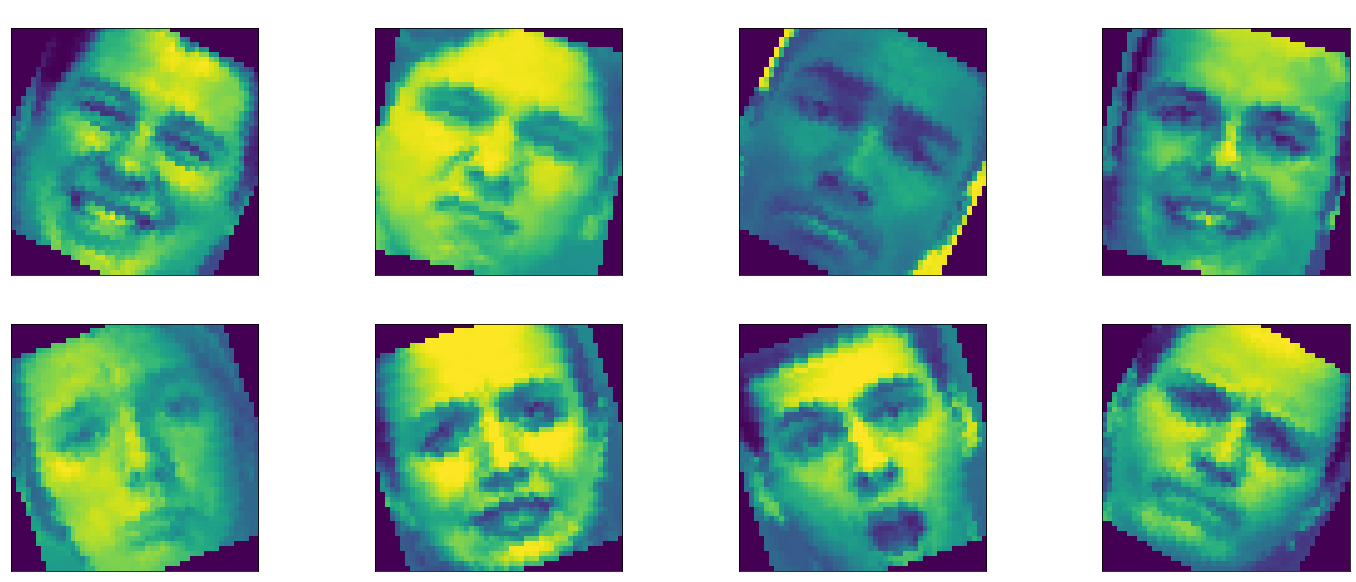

In [203]:

# define samplers for obtaining training and validation batche
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
val_sampler = SubsetRandomSampler(val_idx)


dataset_sizes = {
    'train' : len(train_idx),
    'test' : len(test_idx),
    'val' : len(val_idx)
}

batch_size = 32

loaders = {
    'train': torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler=train_sampler),
    'test': torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler=test_sampler),
    'val': torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler=val_sampler),
}



def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = np.asarray(img)
    plt.imshow(np_img)


dataiter = iter(loaders['train'])
images, labels = dataiter.next()
print(images.shape,labels.shape)
images = images.numpy() 
fig = plt.figure(figsize=(25, 10))

for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(categories[int(labels[idx])],fontsize=20,color='white')

In [204]:
import torch.nn as nn
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F


class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels,
                                   bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class ResidualBlock(nn.Module):

    def __init__(self, in_channeld, out_channels):
        super(ResidualBlock, self).__init__()

        self.residual_conv = nn.Conv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=1, stride=2,
                                       bias=False)
        self.residual_bn = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)

        self.sepConv1 = SeparableConv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.elu = nn.ELU()

        self.sepConv2 = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        res = self.residual_conv(x)
        res = self.residual_bn(res)
        x = self.sepConv1(x)
        x = self.bn1(x)
        x = self.elu(x)
        x = self.sepConv2(x)
        x = self.bn2(x)
        x = self.maxp(x)
        return res + x


class Block(nn.Module):

    def __init__(self, in_channeld, out_channels):
        super(Block, self).__init__()

        self.sep1 = SeparableConv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=3, bias=False, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.elu1 = nn.ELU()
        self.sep2 = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.elu2 = nn.ELU()
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.sep1(x)
        x = self.bn1(x)
        x = self.elu1(x)

        x = self.sep2(x)
        x = self.bn2(x)
        x = self.elu2(x)
        x = self.maxp(x)

        return x


class SELayer(nn.Module):
    def __init__(self, in_channeld, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channeld, in_channeld // reduction, bias=False),
            nn.ReLU6(inplace=True),
            nn.Linear(in_channeld // reduction, in_channeld, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channeld, out_channels, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.Conv1 = nn.Conv2d(in_channeld, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(in_channeld)
        self.relu = nn.ReLU6(inplace=True)

        self.Conv2 = nn.Conv2d(in_channeld, out_channels, 1)
        self.bn2 = nn.BatchNorm2d(in_channeld)
        self.se = SELayer(in_channeld, reduction)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.Conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.Conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Model(nn.Module):

    def __init__(self, num_classes):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, dilation=2, bias=False)
        self.bn1 = nn.BatchNorm2d(8, affine=True, momentum=0.99, eps=1e-3)
        self.relu1 = nn.ELU()
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, dilation=2, bias=False)
        self.bn2 = nn.BatchNorm2d(8, momentum=0.99, eps=1e-3)
        self.relu2 = nn.ELU()


        self.module1 = ResidualBlock(in_channeld=8, out_channels=16)
        self.module2 = SEBasicBlock(16, 16, stride=1, downsample=None, groups=1,
                                    base_width=64, dilation=1, norm_layer=None, reduction=16)
        self.module3 = Block(in_channeld=16, out_channels=32)
        self.module4 = ResidualBlock(in_channeld=32, out_channels=64)
        self.module5 = SEBasicBlock(64, 64, stride=1, downsample=None, groups=1,
                                    base_width=64, dilation=1, norm_layer=None, reduction=16)
        self.module6 = Block(in_channeld=64, out_channels=128)


        self.last_conv = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=3, padding=1, stride=2)
        self.avgp = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, input):
        x = input
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.module1(x)
        x = self.module2(x)
        x = self.module3(x)
        x = self.module4(x)
        x = self.module5(x)
        x = self.module6(x)
        x = self.last_conv(x)
        x = self.avgp(x)
        x = x.view((x.shape[0], -1))
        return x



In [205]:
def graph_loss(avg_train_losses, avg_val_losses):
    fig,ax = plt.subplots(1,1,figsize=(10,8))
    ax.plot(avg_train_losses)
    ax.plot(avg_val_losses)
    ax.legend(['Train Loss','val Loss'])

    minposs = avg_val_losses.index(min(avg_val_losses))+1
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')


In [206]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [207]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
patience = 20

In [208]:

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    train_losses, val_losses = [], []
    avg_train_losses, avg_val_losses = [], []

    since = time.time()

    early_stopping = EarlyStopping(patience = patience, verbose = True)

    for epoch in range(1, num_epochs +1) :
    
        for phase in ['train', 'val']:
            if phase == 'train':
        
                model.train()  

                for batch, (inputs, labels) in enumerate(loaders['train'], 1):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()

                    train_losses.append(loss.item())


            if phase == 'val':
                model.eval()
                
                with torch.no_grad():
                    
                    for batch, (inputs, labels) in enumerate(loaders['val']):
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                          
                        outputs = model(inputs)
                        val_loss = criterion(outputs, labels)
                        val_losses.append(val_loss.item())

                    train_loss = np.average(train_losses)
                    val_loss = np.average(val_losses)
                    avg_train_losses.append(train_loss)
                    avg_val_losses.append(val_loss)

                    epoch_len = len(str(num_epochs))

                    print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                                f'train_loss: {train_loss:.4f} ' +
                                f'valid_loss: {val_loss:.4f}')

                    print(print_msg)

                    train_losses = []
                    val_losses = []

                    early_stopping(val_loss, model)
                    if early_stopping.early_stop:
                        print("Early stopping")
                        break


  
    model.load_state_dict(torch.load('checkpoint.pt'))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    graph_loss(avg_train_losses, avg_val_losses)

    return model_ft, avg_train_losses, avg_val_losses


In [209]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [210]:
model_ft = Model(num_classes=7)
model_ft = model_ft.to(device)
print(summary(model_ft,(1,50,50)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), momentum=0.9,lr=0.02, weight_decay=5e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              72
       BatchNorm2d-2            [-1, 8, 46, 46]              16
               ELU-3            [-1, 8, 46, 46]               0
            Conv2d-4            [-1, 8, 42, 42]             576
       BatchNorm2d-5            [-1, 8, 42, 42]              16
               ELU-6            [-1, 8, 42, 42]               0
            Conv2d-7           [-1, 16, 21, 21]             128
       BatchNorm2d-8           [-1, 16, 21, 21]              32
            Conv2d-9            [-1, 8, 42, 42]              72
           Conv2d-10           [-1, 16, 42, 42]             128
  SeparableConv2d-11           [-1, 16, 42, 42]               0
      BatchNorm2d-12           [-1, 16, 42, 42]              32
              ELU-13           [-1, 16, 42, 42]               0
           Conv2d-14           [-1, 16,

[  1/100] train_loss: 2.4805 valid_loss: 2.0355
Validation loss decreased (inf --> 2.035493).  Saving model ...
[  2/100] train_loss: 1.8094 valid_loss: 1.9162
Validation loss decreased (2.035493 --> 1.916164).  Saving model ...
[  3/100] train_loss: 1.3064 valid_loss: 1.2858
Validation loss decreased (1.916164 --> 1.285798).  Saving model ...
[  4/100] train_loss: 0.9411 valid_loss: 1.1680
Validation loss decreased (1.285798 --> 1.167976).  Saving model ...
[  5/100] train_loss: 0.8662 valid_loss: 0.7513
Validation loss decreased (1.167976 --> 0.751250).  Saving model ...
[  6/100] train_loss: 0.6933 valid_loss: 0.9808
EarlyStopping counter: 1 out of 20
[  7/100] train_loss: 0.5502 valid_loss: 0.5906
Validation loss decreased (0.751250 --> 0.590581).  Saving model ...
[  8/100] train_loss: 0.4027 valid_loss: 0.5756
Validation loss decreased (0.590581 --> 0.575645).  Saving model ...
[  9/100] train_loss: 0.3514 valid_loss: 0.6515
EarlyStopping counter: 1 out of 20
[ 10/100] train_loss

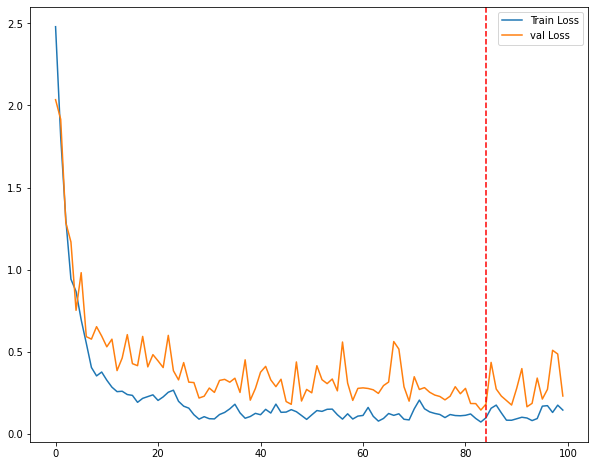

In [211]:
model, train_loss, val_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,num_epochs=100)

In [246]:
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for data in loaders['test']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()  #예측과 실제 라벨 비교
        loss = criterion(outputs, labels)
        test_loss += loss.item()*images.size(0)
                
        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

test_loss = test_loss/len(test_idx)
print('Test Loss: {:.6f}\n'.format(test_loss))

print('Accuracy of the network on test images: %4f %%' % (
    100 * correct / total))            
            
for i in range(7):
    print('Accuracy of %5s : %4f %%' % (
        categories[i], 100 * class_correct[i] / class_total[i])) 

Test Loss: 0.176190

Accuracy of the network on test images: 93.766234 %
Accuracy of anger : 76.190476 %
Accuracy of contempt : 100.000000 %
Accuracy of disgust : 97.435897 %
Accuracy of  fear : 84.615385 %
Accuracy of happy : 100.000000 %
Accuracy of sadness : 87.500000 %
Accuracy of surprise : 97.435897 %


<Figure size 432x288 with 0 Axes>

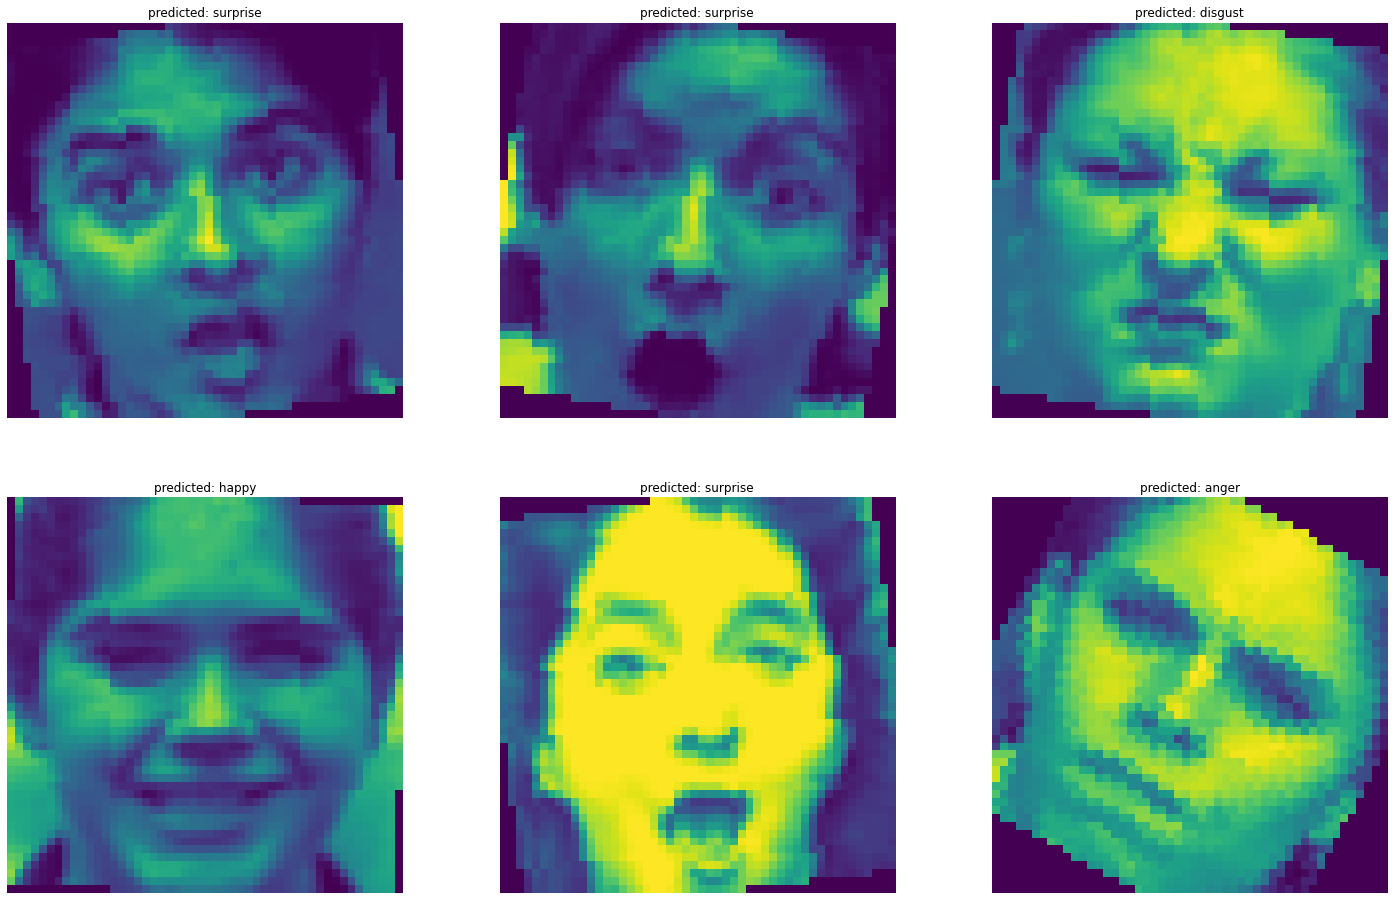

In [248]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            fig = plt.figure(figsize=(25, 16))

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = fig.add_subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(categories[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


visualize_model(model_ft, num_images=6)

In [ ]:
# dilation = 2 추가